## AGENDA OF THE NOTEBOOK

1. Build the database with an embeddings model with chromaDB of all the books data and YouTube data
2. Build the RAG pipeline with three configurations

In [1]:
import sys
sys.path.append('../')

from src.book_preprocess import get_book_data

In [2]:
from tqdm import tqdm
import os
import json

import json
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter

sentence_text_parser = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=20
)

def get_book_transcripts_data():
    book_doc_data = get_book_data(100)
    with open('../artifacts/YouTube_API_Transcripts/chunked_transcripts_mba.json', 'r') as file:
        mba_data = json.load(file)

    with open('../artifacts/YouTube_API_Transcripts/chunked_transcripts_undergrad.json', 'r') as file:
        undergrad_data = json.load(file)

    with open('../artifacts/YouTube_API_Transcripts/chunked_misc_transcripts.json', 'r') as file:
        misc_data = json.load(file)
    
    all_data_list = []
    for book_doc in book_doc_data:
        # try:
        if book_doc=={}: continue
        text_data = book_doc['text']
        splitted_chunks = sentence_text_parser.split_text(text_data)
        curr_book_source = book_doc['book_source']
        curr_page_num_coordinates = book_doc['page_num_coordinates']
        for splitted_text in splitted_chunks:
            if len(splitted_text.split(" "))<=10: continue
            all_data_list.append(
                Document(
                    text=splitted_text,
                    metadata={
                        'page_num_coordinates':curr_page_num_coordinates,
                        'book_source':curr_book_source,
                    },
                    excluded_embed_metadata_keys=['page_num_coordinates','book_source'],
                    excluded_llm_metadata_keys=['page_num_coordinates','book_source'],
                )
            )
    for json_data in [undergrad_data,mba_data,misc_data]:
        for youtube_id, text_list in json_data.items():
            # curr_youtube_id_text = ""
            for text_dict in text_list:
                if len(text_dict['text'].split(" "))<=10:continue
                all_data_list.append(
                    Document(
                        text=text_dict['text'],
                        metadata={
                            "youtube_id":youtube_id,
                            "start_timestamp":text_dict['start_time'],
                        },
                        excluded_embed_metadata_keys=['youtube_id','start_timestamp'],
                        excluded_llm_metadata_keys=['youtube_id','start_timestamp'],
                    )
                )
            # break
    return all_data_list

def median(lst):

    lst.sort()
    return lst[len(lst)//2]

def get_book_data(num_para_words:int=50):
    books_folder = "../artifacts/book_hi_res"
    book_data = []
    for book_name in tqdm(os.listdir(books_folder)):
        # print(book_name)
        if book_name.startswith("Corporate_Finance"):continue
        curr_json_path = os.path.join(books_folder, book_name)
        if book_name.startswith("Narrative"):
            start_page = 1
            end_page = 266
        elif book_name.startswith("Little"):
            start_page = 17
            end_page = None
        elif book_name.startswith("Investment_Philosophies"):
            start_page = 1
            end_page = 486
        elif book_name.startswith("Dark"):
            start_page = 1
            end_page = 794
        elif book_name.startswith("Damodaran"):
            start_page = 1
            end_page = 1237
        else:
            start_page = 1
            end_page = None
        
        #Load the data
        with open(curr_json_path, "r") as f:
            json_data = json.load(f)
        x_start = []
        for jd in json_data:
            x_start.append(jd['coordinates'][0][0])
        x_median = median(x_start)
        metadata_book_name = book_name.split(".")[0]
        for jd_idx,jd in enumerate(json_data):
            text_split_list = jd['text'].split(" ")
            num_words = len(text_split_list)
            x_coord = jd['coordinates'][0][0]
            page_num = jd['page_num']
            txt = jd['text']
            # txt = re.sub("\. ",".\n",txt)
            if start_page == 1 and end_page == None:
                pass
            elif start_page>page_num:
                continue
            elif end_page is not None and end_page<page_num:
                continue
            if jd_idx==0 or (x_median-10<=x_coord <= x_median+10 and text_split_list[0].istitle() and num_words>num_para_words):
                book_data.append(
                    {
                        "text": txt+"\n\n",
                    }
                )
                page_coordinates = jd['coordinates'].copy()
                page_coordinates.insert(0,{"page_num":page_num})
                book_data[-1]["page_num_coordinates"] = [page_coordinates]
                book_data[-1]['book_source'] = metadata_book_name
            else:
                prev_idx = book_data[-1]
                if "text" in prev_idx:
                    prev_idx['text'] = prev_idx['text'][:-2] + txt + "\n\n"
                else:
                    prev_idx['text'] = txt + "\n\n"
                page_coordinates = jd['coordinates'].copy()
                page_coordinates.insert(0,{"page_num":page_num})
                if "page_num_coordinates" not in prev_idx:
                    prev_idx["page_num_coordinates"] = [page_coordinates]
                else:
                    prev_idx["page_num_coordinates"].append(page_coordinates)
                if "book_source" not in prev_idx:
                    prev_idx['book_source'] = metadata_book_name
        book_data.append({})
    return book_data

# all_data_list = get_book_transcripts_data()

100%|██████████| 11/11 [00:00<00:00, 17.19it/s]


In [3]:
# num_words = [len(i.text.split(" ")) for i in all_data_list]
# max(num_words)

500

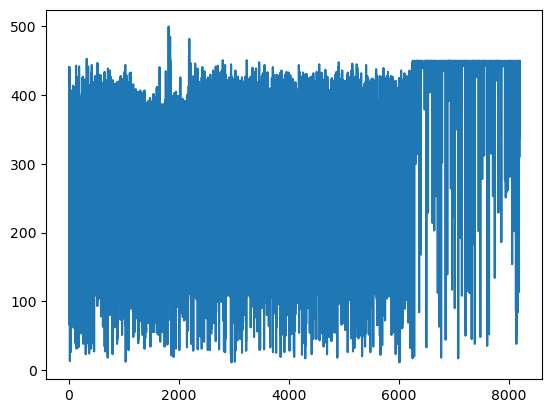

In [4]:
# import matplotlib.pyplot as plt

# plt.plot(num_words)

In [5]:
# min(num_words)

11

In [6]:
# import nomic
# nomic.login(token="nk-tVeW7HFVrX_C7AWKDYIT5YdjMD5f8PhnflQtIZTnWmA")

In [7]:
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import chromadb
from sentence_transformers import SentenceTransformer
from llama_index.legacy.embeddings.huggingface import HuggingFaceEmbedding


database_name = "AD-PROJECT-NOMIC"
EMBEDDING_MODEL = "nomic-ai/nomic-embed-text-v1.5"
COLLECTION_NAME = "ad-project"

def create_database():
    all_data_list = get_book_transcripts_data()
    
    ad_project_db = chromadb.PersistentClient(path=database_name)
    ad_project_chroma_collection = ad_project_db.get_or_create_collection(COLLECTION_NAME)
    embed_model = HuggingFaceEmbedding(model_name="mixedbread-ai/mxbai-embed-large-v1",embed_batch_size=4)
    vector_store = ChromaVectorStore(chroma_collection=ad_project_chroma_collection)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(
        all_data_list, storage_context=storage_context, embed_model=embed_model,
        show_progress=True
    )

    return index

In [8]:
create_database()

100%|██████████| 11/11 [00:00<00:00, 13.06it/s]


Parsing nodes:   0%|          | 0/8205 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

: 